Train size: 3303
Val size: 366
Test size: 344

VALIDATION SET PERFORMANCE
MAE:  0.8420 mm
RMSE: 2.3997 mm
R²:   0.9770

TEST SET PERFORMANCE
MAE:  1.0743 mm
RMSE: 4.8551 mm
R²:   0.9250
MAPE: 55111324025.63%

Akurasi dalam ±5mm:  95.35%
Akurasi dalam ±10mm: 97.38%

Mean Error: -0.7245 mm (bias)
Std Error:  4.8008 mm

✓ Visualisasi disimpan sebagai 'test_set_evaluation.png'


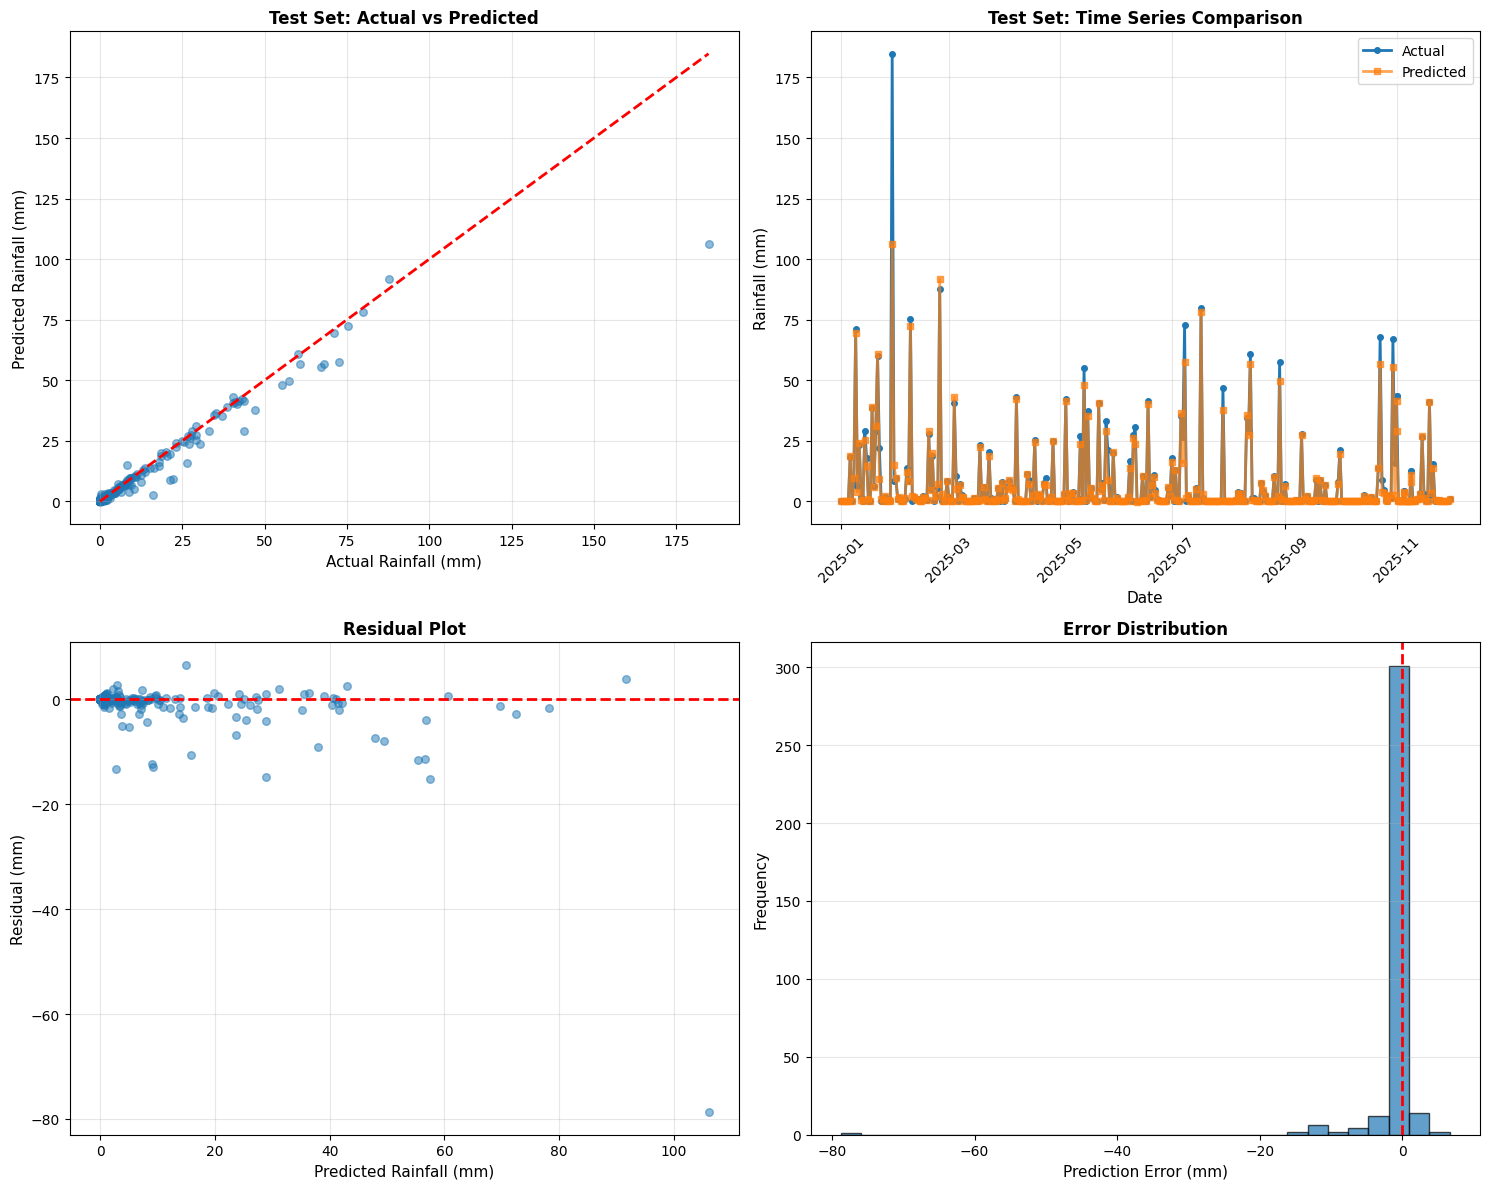


ANALISIS ERROR DETAIL

Performa per Kategori Hujan:
Sangat Ringan  : MAE =   0.20 mm (n=250)
Ringan         : MAE =   1.41 mm (n=49)
Sedang         : MAE =   3.12 mm (n=33)
Lebat          : MAE =  12.22 mm (n=12)

5 Prediksi Terburuk:
   Tanggal  Actual  Predicted      Error
2025-01-29   184.8 106.062302 -78.737698
2025-07-08    72.7  57.433937 -15.266063
2025-11-01    43.6  28.837864 -14.762136
2025-10-31    16.0   2.739970 -13.260030
2025-01-22    22.1   9.141013 -12.958987

PREDIKSI 7 HARI KE DEPAN
   Tanggal  XGB_Pred
2025-12-01  1.692133
2025-12-02  1.797065
2025-12-03  1.565409
2025-12-04  1.207048
2025-12-05  0.628456
2025-12-06  0.014754
2025-12-07 -0.005652


C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_24488\1221360708.py:313: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future = future.fillna(method="ffill").fillna(0)
C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_24488\1221360708.py:313: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future = future.fillna(method="ffill").fillna(0)
C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_24488\1221360708.py:313: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future = future.fillna(method="ffill").fillna(0)
C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_24488\1221360708.py:313: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  futur

In [7]:
# =====================================================================
# 1. IMPORT
# =====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# =====================================================================
# 2. LOAD DATA
# =====================================================================
df = pd.read_excel("updated_dataset_final - Copy.xlsx", parse_dates=['Tanggal'])
df = df.sort_values("Tanggal").reset_index(drop=True)

# Pastikan kolom numerik dibersihkan dari TYPE object
num_cols = [
    'Temperatur Minimum','Temperatur Maksimum','Temperatur Rata-rata',
    'Kelembapan Rata-rata','Curah Hujan (mm)',
    'Lamanya Penyinaran Matahari','Arah Angin Terbanyak (°)'
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Replace 8888 → NaN
df.replace(8888, np.nan, inplace=True)

# =====================================================================
# 3. ADD BASIC FEATURES
# =====================================================================
def add_safe_features(df):
    df = df.copy()

    df["month"] = df["Tanggal"].dt.month
    df["day"]   = df["Tanggal"].dt.day

    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
    df["day_sin"]   = np.sin(2*np.pi*df["day"]/31)
    df["day_cos"]   = np.cos(2*np.pi*df["day"]/31)

    df["temp_range"] = df["Temperatur Maksimum"] - df["Temperatur Minimum"]

    return df

df = add_safe_features(df)

# =====================================================================
# 4. TRAIN / VAL / TEST SPLIT (NO LEAKAGE)
# =====================================================================
train = df[df['Tanggal'] < '2024-01-01']
val   = df[(df['Tanggal'] >= '2024-01-01') & (df['Tanggal'] < '2025-01-01')]
test  = df[df['Tanggal'] >= '2025-01-01']

print(f"Train size: {len(train)}")
print(f"Val size: {len(val)}")
print(f"Test size: {len(test)}")

# =====================================================================
# 5. ADD SAFE LAG + ROLLING
# =====================================================================
def add_leakage_safe_lags(train, val, test):
    full = pd.concat([train, val, test], axis=0).sort_index()

    full["Curah Hujan (mm)_lag1"] = full["Curah Hujan (mm)"].shift(1)
    full["Curah Hujan (mm)_lag2"] = full["Curah Hujan (mm)"].shift(2)
    full["Curah Hujan (mm)_lag3"] = full["Curah Hujan (mm)"].shift(3)
    full["Curah Hujan (mm)_lag7"] = full["Curah Hujan (mm)"].shift(7)

    full["Temperatur Rata-rata_lag1"] = full["Temperatur Rata-rata"].shift(1)

    full["Curah Hujan (mm)_diff1"] = (
        full["Curah Hujan (mm)"] - full["Curah Hujan (mm)_lag1"]
    )

    past_rain = full["Curah Hujan (mm)"].shift(1)

    full["Curah Hujan (mm)_7d"]  = past_rain.rolling(7).mean()
    full["Curah Hujan (mm)_14d"] = past_rain.rolling(14).mean()
    full["Curah Hujan (mm)_30d"] = past_rain.rolling(30).mean()

    rain_ind = (full["Curah Hujan (mm)"] > 0).astype(int).shift(1)
    full["Rain_7d_count"] = rain_ind.rolling(7).sum()

    train2 = full.loc[train.index].dropna()
    val2   = full.loc[val.index].dropna()
    test2  = full.loc[test.index].dropna()

    return train2, val2, test2

train2, val2, test2 = add_leakage_safe_lags(train, val, test)

# =====================================================================
# 6. FEATURE SET
# =====================================================================
features = [
    'Temperatur Minimum','Temperatur Maksimum','Temperatur Rata-rata',
    'Kelembapan Rata-rata','Lamanya Penyinaran Matahari',
    'Kecepatan Angin Maksimum','Arah Angin Saat Kecepatan Maksimum',
    'Kecepatan Angin Rata-rata','Arah Angin Terbanyak (°)',

    'Curah Hujan (mm)_lag1','Curah Hujan (mm)_lag2','Curah Hujan (mm)_lag3',
    'Curah Hujan (mm)_lag7','Temperatur Rata-rata_lag1',
    'Curah Hujan (mm)_diff1','Curah Hujan (mm)_7d','Curah Hujan (mm)_14d','Curah Hujan (mm)_30d',
    'Rain_7d_count',

    'month_sin','month_cos','day_sin','day_cos','temp_range'
]

X_train = train2[features]
X_val   = val2[features]
X_test  = test2[features]

# Target log transform
y_train = np.log1p(train2["Curah Hujan (mm)"])
y_val   = np.log1p(val2["Curah Hujan (mm)"])
y_test  = np.log1p(test2["Curah Hujan (mm)"])

# =====================================================================
# 7. SCALING
# =====================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# =====================================================================
# 8. XGBOOST MODEL
# =====================================================================
xgb = XGBRegressor(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

# =====================================================================
# 9. VALIDATION PERFORMANCE
# =====================================================================
pred_val = np.expm1(xgb.predict(X_val_scaled))
y_val_real = np.expm1(y_val)

print("\n" + "="*60)
print("VALIDATION SET PERFORMANCE")
print("="*60)
print(f"MAE:  {mean_absolute_error(y_val_real, pred_val):.4f} mm")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_real, pred_val)):.4f} mm")
print(f"R²:   {r2_score(y_val_real, pred_val):.4f}")

# =====================================================================
# 10. TEST SET EVALUATION (NEW!)
# =====================================================================
pred_test = np.expm1(xgb.predict(X_test_scaled))
y_test_real = np.expm1(y_test)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"MAE:  {mean_absolute_error(y_test_real, pred_test):.4f} mm")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_real, pred_test)):.4f} mm")
print(f"R²:   {r2_score(y_test_real, pred_test):.4f}")

# Metrik tambahan
mape = np.mean(np.abs((y_test_real - pred_test) / (y_test_real + 1e-10))) * 100
print(f"MAPE: {mape:.2f}%")

# Persentase prediksi dalam toleransi
tolerance_5mm = np.mean(np.abs(y_test_real - pred_test) <= 5) * 100
tolerance_10mm = np.mean(np.abs(y_test_real - pred_test) <= 10) * 100
print(f"\nAkurasi dalam ±5mm:  {tolerance_5mm:.2f}%")
print(f"Akurasi dalam ±10mm: {tolerance_10mm:.2f}%")

# Statistik error
errors = pred_test - y_test_real
print(f"\nMean Error: {np.mean(errors):.4f} mm (bias)")
print(f"Std Error:  {np.std(errors):.4f} mm")

# =====================================================================
# 11. VISUALISASI HASIL TEST SET
# =====================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test_real, pred_test, alpha=0.5, s=30)
axes[0, 0].plot([0, y_test_real.max()], [0, y_test_real.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Rainfall (mm)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Rainfall (mm)', fontsize=11)
axes[0, 0].set_title('Test Set: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Time series comparison
test_dates = test2['Tanggal'].values
axes[0, 1].plot(test_dates, y_test_real, 'o-', label='Actual', linewidth=2, markersize=4)
axes[0, 1].plot(test_dates, pred_test, 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.7)
axes[0, 1].set_xlabel('Date', fontsize=11)
axes[0, 1].set_ylabel('Rainfall (mm)', fontsize=11)
axes[0, 1].set_title('Test Set: Time Series Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Residual plot
axes[1, 0].scatter(pred_test, errors, alpha=0.5, s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Rainfall (mm)', fontsize=11)
axes[1, 0].set_ylabel('Residual (mm)', fontsize=11)
axes[1, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error distribution
axes[1, 1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error (mm)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('test_set_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualisasi disimpan sebagai 'test_set_evaluation.png'")
plt.show()

# =====================================================================
# 12. DETAILED ERROR ANALYSIS
# =====================================================================
print("\n" + "="*60)
print("ANALISIS ERROR DETAIL")
print("="*60)

# Kategorisasi prediksi
def categorize_rainfall(value):
    if value < 5:
        return "Sangat Ringan"
    elif value < 20:
        return "Ringan"
    elif value < 50:
        return "Sedang"
    else:
        return "Lebat"

test_df = pd.DataFrame({
    'Tanggal': test2['Tanggal'].values,
    'Actual': y_test_real,
    'Predicted': pred_test,
    'Error': errors,
    'Abs_Error': np.abs(errors),
    'Category': [categorize_rainfall(x) for x in y_test_real]
})

print("\nPerforma per Kategori Hujan:")
for cat in ["Sangat Ringan", "Ringan", "Sedang", "Lebat"]:
    subset = test_df[test_df['Category'] == cat]
    if len(subset) > 0:
        mae_cat = subset['Abs_Error'].mean()
        count = len(subset)
        print(f"{cat:15s}: MAE = {mae_cat:6.2f} mm (n={count})")

# Top 5 worst predictions
print("\n5 Prediksi Terburuk:")
worst = test_df.nlargest(5, 'Abs_Error')[['Tanggal', 'Actual', 'Predicted', 'Error']]
print(worst.to_string(index=False))

# =====================================================================
# 13. FORECAST NEXT DAYS
# =====================================================================
def build_future_features(history_df, future_date):
    history_df = history_df.copy()
    future_date = pd.to_datetime(future_date)

    last_30 = history_df.tail(30).copy()
    base = history_df.iloc[-1].copy()
    base["Tanggal"] = future_date

    # date features
    base["month"] = future_date.month
    base["day"]   = future_date.day
    base["month_sin"] = np.sin(2*np.pi*base["month"]/12)
    base["month_cos"] = np.cos(2*np.pi*base["month"]/12)
    base["day_sin"]   = np.sin(2*np.pi*base["day"]/31)
    base["day_cos"]   = np.cos(2*np.pi*base["day"]/31)
    base["temp_range"] = base["Temperatur Maksimum"] - base["Temperatur Minimum"]

    temp = pd.concat([last_30, pd.DataFrame([base])], ignore_index=True)

    temp["Curah Hujan (mm)_lag1"] = temp["Curah Hujan (mm)"].shift(1)
    temp["Curah Hujan (mm)_lag2"] = temp["Curah Hujan (mm)"].shift(2)
    temp["Curah Hujan (mm)_lag3"] = temp["Curah Hujan (mm)"].shift(3)
    temp["Curah Hujan (mm)_lag7"] = temp["Curah Hujan (mm)"].shift(7)

    temp["Temperatur Rata-rata_lag1"] = temp["Temperatur Rata-rata"].shift(1)
    temp["Curah Hujan (mm)_diff1"] = (
        temp["Curah Hujan (mm)"].shift(1) - temp["Curah Hujan (mm)"].shift(2)
    )

    rain_past = temp["Curah Hujan (mm)"].shift(1)
    temp["Curah Hujan (mm)_7d"]  = rain_past.rolling(7).mean()
    temp["Curah Hujan (mm)_14d"] = rain_past.rolling(14).mean()
    temp["Curah Hujan (mm)_30d"] = rain_past.rolling(30).mean()

    rain_ind = (temp["Curah Hujan (mm)"] > 0).astype(int).shift(1)
    temp["Rain_7d_count"] = rain_ind.rolling(7).sum()

    future = temp.iloc[-1:].copy()
    future = future.fillna(method="ffill").fillna(0)

    return future

def forecast_7_days(df, start_date, features, scaler, xgb):
    history = df.copy()
    results = []
    current_date = pd.to_datetime(start_date)

    for i in range(7):
        next_date = current_date + pd.Timedelta(days=1)
        future_row = build_future_features(history, next_date)
        scaled = scaler.transform(future_row[features])

        pred = np.expm1(xgb.predict(scaled)[0])

        results.append({"Tanggal": next_date, "XGB_Pred": pred})

        future_row["Curah Hujan (mm)"] = pred
        history = pd.concat([history, future_row], ignore_index=True)

        current_date = next_date

    return pd.DataFrame(results)

print("\n" + "="*60)
print("PREDIKSI 7 HARI KE DEPAN")
print("="*60)
future_7d = forecast_7_days(
    df=df,
    start_date="2025-11-30",
    features=features,
    scaler=scaler,
    xgb=xgb
)

print(future_7d.to_string(index=False))